# Base Imputation: K-Nearest Neighbors

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [2]:
# only use top 200 highly variable genes
adata = sc.read_h5ad('top200hvg_raw.h5ad')

In [3]:
adata.shape

(9992, 200)

### create a mask for the NaN values

In [4]:
mask = np.isnan(adata.X)
nan_count = mask.sum()
print(f"total NaN values: {nan_count}")
print(f"total values: {adata.X.size}")
print(f"percent NaN: {(nan_count / adata.X.size) * 100}%")
print(f"Cells with NaNs: {np.isnan(adata.X).any(axis=1).sum()} / {adata.n_obs}")
print(f"Genes with NaNs: {np.isnan(adata.X).any(axis=0).sum()} / {adata.n_vars}")

total NaN values: 571955
total values: 1998400
percent NaN: 28.62064651721377%
Cells with NaNs: 9991 / 9992
Genes with NaNs: 200 / 200


## function to compute either mean or median of KNN

In [5]:
def impute_knn(data, n_neighbors, avg, max_it = 5):
    """
    Impute all the NaN values as the mean or median of KNN for each cell
    -------
    Parameters:
    adata : AnnData
        adata object you want to impute
    n_neighbors : int
        the number of k-neighbors you want to use to calculate the knn
    avg : string
        use to determine if you want to calculate the mean or median of the KNN
    max_it : int
        the maximum number of iterations; default: 5 iterations 
    -------
    Return:
    Nothing
        only impute the NaN values
    """
    
    # make sure that X is a dense array
    if hasattr(data.X, 'toarray'):
        X = data.X.toarray()
    else:
        X=data.X.copy()
    
    # count the initial number of NaN values 
    initial_nan = np.isnan(X).sum()
    
    # replace the NaN values with 0.0
    #     cannot run KNN with NaN values 
    X_for_knn = np.nan_to_num(X, nan=0.0)
    
    # find the K nearest neighbors for each cell 
    knn = NearestNeighbors(n_neighbors=n_neighbors + 1, metric='correlation')
    knn.fit(X_for_knn)
    distances, indices = knn.kneighbors(X_for_knn)
    
    # remove the first neighbor (itself) from each row
    indices = indices[:, 1:]
    
    # prepare for imputation
    # make a copy and a mask of all NaN values
    X_imputed = X.copy()
    nan_mask = np.isnan(X)
    
    # create a 3D array with the feature values of K nearest neighbors for each cell
    all_neighbor_values = X[indices]
    
    # calculates either the mean or median of neighbor values
    if avg == "median":
        imputed_matrix = np.nanmedian(all_neighbor_values, axis=1)
    else:
        imputed_matrix = np.nanmean(all_neighbor_values, axis=1)
            
    # fill in NaN values with the average of the neighbors 
    X_imputed[nan_mask] = imputed_matrix[nan_mask]
    
    # update the adata with the imputed data 
    data.X = X_imputed
    
    # count number of remaining NaN values
    final_nan = np.isnan(data.X).sum()
    
    # handle remaining remaining NaN values
    #      if there are any remaining, iterate through until there are no more left or until it reaches the maximum number of iterations
    #      fallback: replace remaining NaN values with average of all non-NaN values in that feature column
    final_mask = np.isnan(data.X)
    if final_nan>0:
        progress = final_nan < initial_nan
        
        if progress and max_it > 1:
            print(f"Imputed {initial_nan - final_nan} values. {final_nan} remaining. Trying again...")
            print(f"Iteration #{6-max_it}")
            impute_knn(data, n_neighbors, avg, max_it-1)
            
        else:
            if not progress:
                print(f"Could not impute {final_nan} values. No progress made.")
            else:
                print(f"Could not impute {final_nan} values. Max iterations reached.")
                
            for gene_idx in range(data.X.shape[1]):
                gene_col = data.X[:, gene_idx]
                if np.isnan(gene_col).any():
                    if avg == "median":
                        global_val = np.nanmedian(gene_col)
                    else:
                        global_val = np.nanmean(gene_col) 
                    if np.isnan(global_val):
                        global_val = 0.0
                    gene_col[np.isnan(gene_col)] = global_val
                data.X[:, gene_idx] = gene_col
    elif avg == "median":
        print(f"Imputed all NaN values as the median of the {n_neighbors} most similar cells.")
    else:
        print(f"Imputed all NaN values as the mean of the {n_neighbors} most similar cells.")
            

### replace all NaN values with the mean knn

In [6]:
%%time
impute_knn(data=adata, n_neighbors=35, avg="mean")

Imputed all NaN values as the mean of the 35 most similar cells.
CPU times: user 7.59 s, sys: 2.39 s, total: 9.98 s
Wall time: 10 s


In [7]:
mask = np.isnan(adata.X)
nan_count = mask.sum()
print(f"total NaN values: {nan_count}")
print(f"total values: {adata.X.size}")
print(f"percent NaN: {(nan_count / adata.X.size) * 100}%")
print(f"Cells with NaNs: {np.isnan(adata.X).any(axis=1).sum()} / {adata.n_obs}")
print(f"Genes with NaNs: {np.isnan(adata.X).any(axis=0).sum()} / {adata.n_vars}")

total NaN values: 0
total values: 1998400
percent NaN: 0.0%
Cells with NaNs: 0 / 9992
Genes with NaNs: 0 / 200


#### create umap

In [8]:
sc.pp.scale(adata, max_value=10)

In [9]:
sc.tl.pca(adata, svd_solver="arcpack")

/u/home/e/ekliao/.conda/envs/sctorch_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:537: UserWarning: Ignoring svd_solver='arcpack' and using arpack, sklearn.decomposition._pca.PCA only supports dict_keys(['auto', 'full', 'randomized', 'arpack', 'covariance_eigh']).
  warnings.warn(msg)


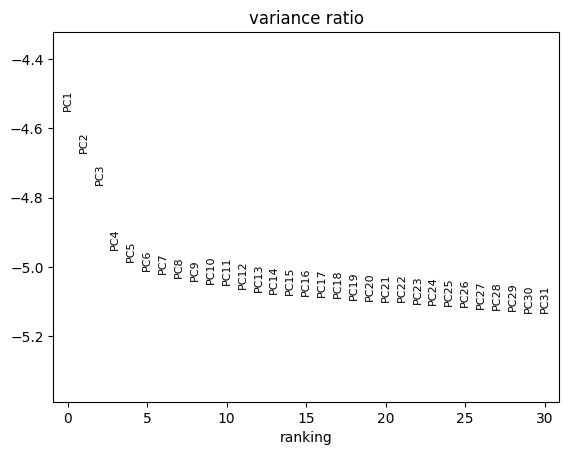

In [10]:
# can choose the pcs based on where the graph starts to flatten
sc.pl.pca_variance_ratio(adata, log=True)

In [11]:
# since there is about 10k cells in our dataset we can choose 15 n_neightbors
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=13)

/u/home/e/ekliao/.conda/envs/sctorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1)

/tmp/ipykernel_30348/3317368278.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1)


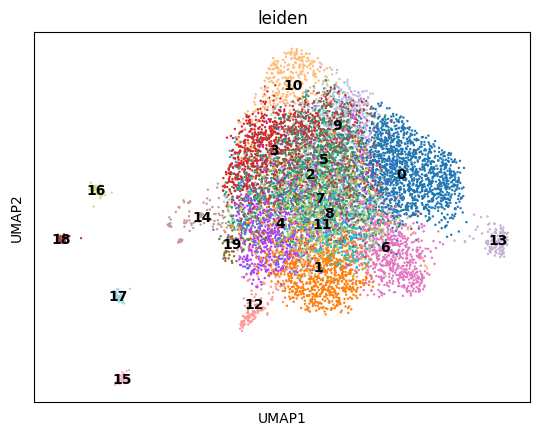

In [13]:
sc.pl.umap(adata, color='leiden', legend_loc='on data')

### replace all NaN values with the median knn

In [14]:
adata = sc.read_h5ad('top200hvg_raw.h5ad')

In [15]:
impute_knn(data=adata, n_neighbors=35, avg="median")

Imputed all NaN values as the median of the 35 most similar cells.


#### create umap

In [16]:
sc.pp.scale(adata, max_value=10)

In [17]:
sc.tl.pca(adata, svd_solver="arcpack")

/u/home/e/ekliao/.conda/envs/sctorch_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:537: UserWarning: Ignoring svd_solver='arcpack' and using arpack, sklearn.decomposition._pca.PCA only supports dict_keys(['auto', 'full', 'randomized', 'arpack', 'covariance_eigh']).
  warnings.warn(msg)


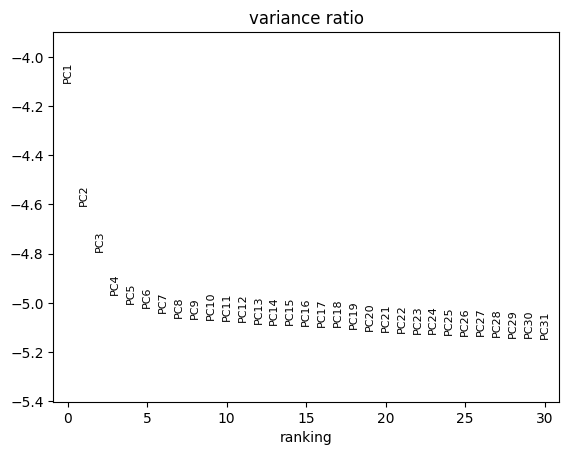

In [18]:
# can choose the pcs based on where the graph starts to flatten
sc.pl.pca_variance_ratio(adata, log=True)

In [19]:
# since there is about 10k cells in our dataset we can choose 15 n_neightbors
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=10)

In [20]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1)

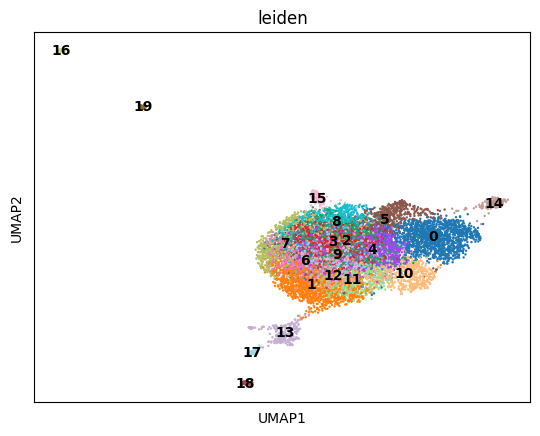

In [21]:
sc.pl.umap(adata, color='leiden', legend_loc='on data')